In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [418]:
import os
import glob
from typing import NamedTuple

In [7]:
glob.glob(os.path.join('..', 'measurements', 'logic', '24 MHz', '*.csv'))

['../measurements/logic/24 MHz/Only B enabled (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only C in sight (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Both in sight (24 MHz, 240 M Samples).csv',
 '../measurements/logic/24 MHz/Only B in sight (24 MHz, 240 M Samples).csv']

For the given data sequences, the sensor diode was placed **about 2 m** away from Lighthouse A (measured directly), roughly **1.4 m** to the left (when looking straight at it), as well as **1.5 m** beneath it. Depending on the direction of the sweep, this places the diode either relatively close to the beginning or the end of it.

Likewise, the diode was placed about **1.5 m** to the right of Lighthouse B (when looking straight at it), as well as about **1.7 m** beneath it, and at a distance of 3.5 m (totaling about **4.2 m**).

In [9]:
csv_files = glob.glob(os.path.join('..', 'measurements', 'logic', '24 MHz', 'Both*.csv'))
csv_files

['../measurements/logic/24 MHz/Both in sight (24 MHz, 240 M Samples).csv']

In [125]:
df_src = pd.read_csv(csv_files[0], names=['Time [s]', 'Level'], skiprows=1)
df_src.dtypes

Time [s]    float64
Level         int64
dtype: object

In [126]:
df_src.describe()

,Time [s],Level
count,5704.000000,5704.000000
mean,4.958682,0.500000
std,2.895296,0.500044
min,-0.003962,0.000000
25%,2.441960,0.000000
50%,4.958811,0.500000
75%,7.459004,1.000000
max,10.001287,1.000000


In [127]:
df_src.head(n=8)

,Time [s],Level
0,-0.003962,0
1,0.000000,1
2,0.000075,0
3,0.000408,1
4,0.000538,0
5,0.003094,1
6,0.003108,0
7,0.008335,1


Let's visualize the pulses to see whether the data makes sense at a first glance.

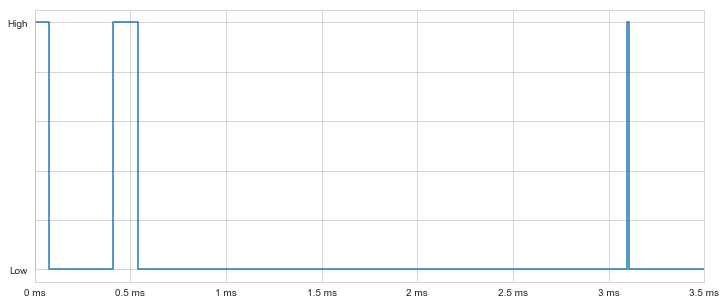

In [161]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.0035]);
ax.set_xticklabels(['0 ms', '0.5 ms', '1 ms', '1.5 ms', '2 ms', '2.5 ms', '3 ms', '3.5 ms']);
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

That seems to be fine. Let's look at a longer sequence.

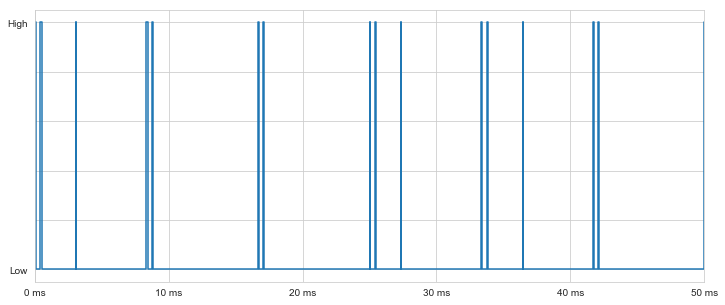

In [163]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.05])
ax.set_xticklabels(['0 ms', '10 ms', '20 ms', '30 ms', '40 ms', '50 ms'])
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

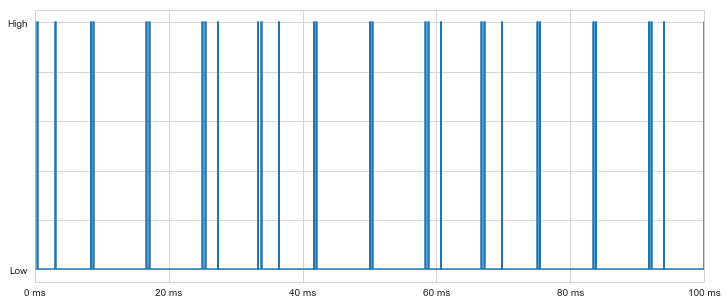

In [162]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.step(x=df_src['Time [s]'], y=df_src['Level'], where='post');
ax.set_xlim([0, 0.1])
ax.set_xticklabels(['0 ms', '20 ms', '40 ms', '60 ms', '80 ms', '100 ms'])
ax.set_yticklabels(['', 'Low', '', '', '', '', 'High']);

Next, we determine the durations of the high and low states by taking the piecewise difference to the next state.

In [167]:
df_durations = (df_src.shift(-1)['Time [s]'] - df_src['Time [s]']).to_frame(name='Duration [s]')
df = df_src.join(df_durations)
df.head(10)

,Time [s],Level,Duration [s]
0,-0.003962,0,0.003962
1,0.000000,1,0.000075
2,0.000075,0,0.000333
3,0.000408,1,0.000130
4,0.000538,0,0.002555
5,0.003094,1,0.000014
6,0.003108,0,0.005227
7,0.008335,1,0.000106
8,0.008441,0,0.000302
9,0.008743,1,0.000077


For further insights, we're going to isolate the High pulses and convert them to microseconds.

In [225]:
def sec_to_us(t: float) -> float:
    return t * 1_000_000

In [352]:
def us_to_sec(t: float) -> float:
    return t / 1_000_000

In [473]:
df_high_filter = df['Level'] > 0
df_high_durations = df.loc[df_high_filter, 'Duration [s]']
df_high_durations_us = sec_to_us(df_high_durations).to_frame(name='Duration [µs]').dropna()

The statistics give that the pulse duration ranges from 0.625 µs to about 137.792 µs:

In [474]:
df_high_durations_us.describe()

,Duration [µs]
count,2851.000000
mean,76.261999
std,43.130309
min,0.625000
25%,54.437500
50%,85.250000
75%,110.041667
max,137.791667


Given the lower and upper boundary for the pulse durations, we can now inspect the histogram.

The dotted magenta lines show the positions of the defined OOTX (Omnidirectional Optical Transmitter) sync pulse lengths at

- 62.5 µs, 
- 72.9 µs, 
- 83.3 µs, 
- 93.8 µs,
- 104 µs,
- 115 µs,
- 125 µs and
- 135 µs.

We can see that the histogram peaks are offset from these expected locations quite noticeably. The dash-dotted magenta line indicates the lower bound for peaks, as described later.

In [304]:
sync_peak_end = np.array([62.5, 72.9, 83.3, 93.8, 104, 115, 125, 135])

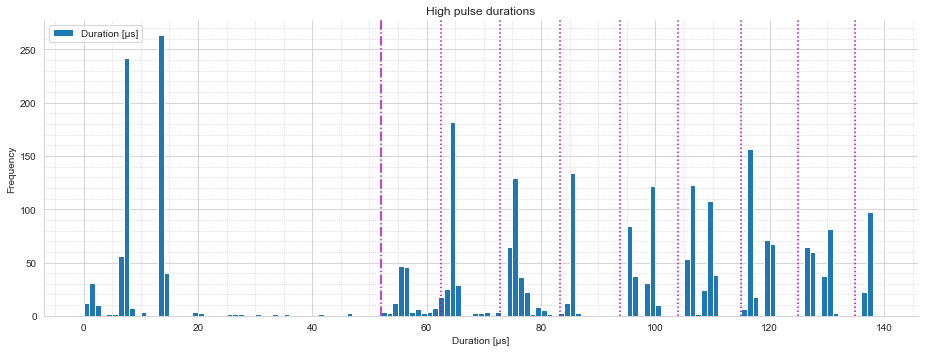

In [475]:
fig, ax = plt.subplots(figsize=(13, 5))
df_high_durations_us.plot.hist(bins=np.arange(0, 140, 1), ax=ax);
for x in sync_peak_end:
    ax.axvline(x, 0, 300, color='m', linestyle=':')
ax.axvline(52, 0, 300, color='m', linestyle='-.')
ax.set_xlabel('Duration [µs]')
ax.set_title('High pulse durations')
ax.grid(b=True, which='minor', linestyle=':')
ax.minorticks_on()
sns.despine()
fig.tight_layout();

We also see a high number of pulses at about 7 … 8 µs and 13 … 14 µs. We can expect these to be the laser sweeps.

Pulse length durations as described [here](https://github.com/widemeadows/LighthouseRedox/blob/master/docs/Light%20Emissions.md):

> Name | skip | data | axis  | length (ticks) | length (µs)
> -----|------|------|-------|----------------|------------
> j0   | 0    | 0    | 0     | 3000           | 62.5
> k0   | 0    | 0    | 1     | 3500           | 72.9
> j1   | 0    | 1    | 0     | 4000           | 83.3
> k1   | 0    | 1    | 1     | 4500           | 93.8
> j2   | 1    | 0    | 0     | 5000           | 104
> k2   | 1    | 0    | 1     | 5500           | 115
> j3   | 1    | 1    | 0     | 6000           | 125
> k3   | 1    | 1    | 1     | 6500           | 135
> 
> Each length represents a combination of 3 bit states:
>
> - The **axis** bit determines the rotation axis for the laser sweep that follows the sync pulse.
> - The **skip** bit determines if the rotor will skip this period and leave its laser off.
> - The **data** bits of consecutive sync pulses of a base station concatenated together yield a data structure called OOTX Frame.
>
> In reality the listed sync pulse lengths should be considered maximum values. The real length should be in a 500 tick window ending at the listed length.
> E.g. sync pulse _j0_ can be 2501-3000 ticks long depending on the position and orientation relative to the base station.
>
> Given a measured pulse length the best match can be found using:
>
> `[skip,data,axis] = (length - 2501) / 500`
>
> Given the 3 bits the pulse length can be calculated:
>
> `length = 3000 + axis*500 + data*1000 + skip*2000`

From the above table, we find that each "tick" represents about 0.0208 µs, or 20.83 ns:

In [357]:
tick_us = (sync_peak_end / np.array(range(3000, 7000, 500))).mean()
tick_us

0.020830375527250526

This duration resembles about 48 MHz, which has a period length of $20.8\bar 3 \,s$.

In [358]:
1/us_to_sec(tick_us)

48006815.7528792

What we know is that 48 MHz is related to USB and the numbers align nicely for the above equations. For a microcontroller running at 72 MHz, we'd use tick values in multiples of 750 instead:

In [374]:
print(np.array(range(3000, 7000, 500)) / 48_000_000 * 72_000_000, '\n',
      500 / 48_000_000 * 72_000_000)

[4500. 5250. 6000. 6750. 7500. 8250. 9000. 9750.] 
 750.0


As for the skew, we allow for a window of 500 ticks at 48 MHz, or about 10.42 µs:

In [382]:
sec_to_us(500 / 48_000_000)

10.416666666666666

Across all values, however, a skew of 10 µs seems to be safer:

In [391]:
np.diff(sync_peak_end)

array([10.4, 10.4, 10.5, 10.2, 11. , 10. , 10. ])

In [397]:
np.sqrt(1.4**2 + 1.5**2), np.sqrt((1.5**2 + 1.7**2) + 3.5**2)

(2.0518284528683193, 4.170131892398609)

In [488]:
OOTXPulse = NamedTuple('OOTXPulse', [('valid', bool), ('name', str), 
                                     ('skip', bool), ('data', int), ('axis', int)])

invalid_pulse = OOTXPulse(valid=False, name='None', skip=False, data=0, axis=0)

ootx_pulses = [
    OOTXPulse(valid=True, name='j-0', skip=False, data=0, axis=0),
    OOTXPulse(valid=True, name='k-0', skip=False, data=0, axis=1),
    OOTXPulse(valid=True, name='j-1', skip=False, data=1, axis=0),
    OOTXPulse(valid=True, name='k-1', skip=False, data=1, axis=1),
    OOTXPulse(valid=True, name='j-2', skip=True, data=0, axis=0),
    OOTXPulse(valid=True, name='k-2', skip=True, data=0, axis=1),
    OOTXPulse(valid=True, name='j-3', skip=True, data=1, axis=0),
    OOTXPulse(valid=True, name='k-3', skip=True, data=1, axis=1)
]

def classify_duration(duration: float) -> OOTXPulse:
    ticks = us_to_sec(duration) * 48_000_000
    pulse_id = int((ticks - 2501) // 500)
    if pulse_id < 0 or pulse_id >= len(ootx_pulses):
        return invalid_pulse
    return ootx_pulses[pulse_id]

classify_duration(93.0)

OOTXPulse(valid=True, name='k-1', skip=False, data=1, axis=1)

In [491]:
df_ootx = df_high_durations_us.apply(lambda row: 
                                     pd.Series(list(classify_duration(row['Duration [µs]'])),
                                               index=['OOTX', 'OOTX Name', 'OOTX Skip', 'OOTX Data', 'OOTX Axis']),
                                     result_type='expand', axis=1)
is_ootx_filter = df_ootx['OOTX'] == True
df_ootx = df_ootx[is_ootx_filter]
df_ootx.head(n=13)

,OOTX,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
1,True,j-1,False,1,0
3,True,k-3,True,1,1
7,True,k-2,True,0,1
9,True,j-1,False,1,0
11,True,j-3,True,1,0
13,True,k-0,False,0,1
15,True,k-0,False,0,1
17,True,j-2,True,0,0
21,True,j-1,False,1,0
23,True,k-3,True,1,1


From the above output we can observe the pattern that stations sweep both their vertical axes, then their horizontal axes (or vice versa) in an alternating pattern. Even though we cannot tell which base station is sending their pulse first, we know that they always pulse in the same order.

In [534]:
def classify_pulse(level: int, duration: float) -> str:
    if level == 0:
        return '-'
    if 0.000005 <= duration <= 0.000015:
        return 'Pulse'
    if 0.000050 <= duration <= 0.000140:
        return 'OOTX'
    return 'Unknown'

df_type = df.apply(lambda row: classify_pulse(row['Level'], row['Duration [s]']), axis=1).to_frame(name='Type').astype('category')

We can now join together all data frames to classify each segment.

In [535]:
df_usec = (df['Duration [s]'] * 1_000_000).to_frame('Duration [µs]')
df_combined = df.join((df_usec, df_type, df_ootx)).drop(columns=['OOTX'])
df_combined.head(n=10)

,Time [s],Level,Duration [s],Duration [µs],Type,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
0,-0.003962,0,0.003962,3961.666667,-,NaN,NaN,NaN,NaN
1,0.000000,1,0.000075,75.291667,OOTX,j-1,False,1.0,0.0
2,0.000075,0,0.000333,332.791667,-,NaN,NaN,NaN,NaN
3,0.000408,1,0.000130,130.250000,OOTX,k-3,True,1.0,1.0
4,0.000538,0,0.002555,2555.375000,-,NaN,NaN,NaN,NaN
5,0.003094,1,0.000014,14.041667,Pulse,NaN,NaN,NaN,NaN
6,0.003108,0,0.005227,5227.041667,-,NaN,NaN,NaN,NaN
7,0.008335,1,0.000106,105.750000,OOTX,k-2,True,0.0,1.0
8,0.008441,0,0.000302,302.291667,-,NaN,NaN,NaN,NaN
9,0.008743,1,0.000077,76.541667,OOTX,j-1,False,1.0,0.0


We also have a handful of values that could not be classified:

In [540]:
df_combined[df_combined.Type == 'Unknown']['Duration [µs]'].describe()

count    88.000000
mean     12.382576
std      15.185101
min       0.625000
25%       1.364583
50%       2.000000
75%      25.395833
max      49.458333
Name: Duration [µs], dtype: float64

When we look at the distribution of values, we find that these are lower than the OOTX frame length even though `OOTX` type classification uses an upper boundary.
Per definition, the area around 10 µs is excluded, but the largest amount of values appears at a duration of 2 µs.
From the data, we find that about 1.6% of our data is "broken".

In [557]:
df_combined.loc[df_combined.Type == 'Unknown', 'Level'].count() / df_combined['Level'].count()

0.015603085553997195

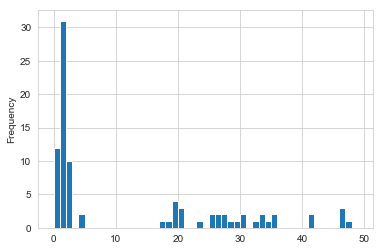

In [543]:
df_combined[df_combined.Type == 'Unknown']['Duration [µs]'].plot.hist(bins=range(0, 50, 1));

In [558]:
df_combined

,Time [s],Level,Duration [s],Duration [µs],Type,OOTX Name,OOTX Skip,OOTX Data,OOTX Axis
0,-0.003962,0,0.003962,3961.666667,-,NaN,NaN,NaN,NaN
1,0.000000,1,0.000075,75.291667,OOTX,j-1,False,1.0,0.0
2,0.000075,0,0.000333,332.791667,-,NaN,NaN,NaN,NaN
3,0.000408,1,0.000130,130.250000,OOTX,k-3,True,1.0,1.0
4,0.000538,0,0.002555,2555.375000,-,NaN,NaN,NaN,NaN
5,0.003094,1,0.000014,14.041667,Pulse,NaN,NaN,NaN,NaN
6,0.003108,0,0.005227,5227.041667,-,NaN,NaN,NaN,NaN
7,0.008335,1,0.000106,105.750000,OOTX,k-2,True,0.0,1.0
8,0.008441,0,0.000302,302.291667,-,NaN,NaN,NaN,NaN
9,0.008743,1,0.000077,76.541667,OOTX,j-1,False,1.0,0.0


In [393]:
J_AXIS_FREQ = 60 # Hz
STATION_FREQ = J_AXIS_FREQ / 2